In [1]:
## packages for data table processing 
library(here)
library(tidyverse)

## main Seurat package snRNA-seq pacakges
library(Seurat)
library(SeuratDisk)
library(future)

ss <- function(x, pattern, slot = 1, ...) { 
  sapply(strsplit(x = x, split = pattern, ...), '[', slot) }
options(stringsAsFactors = F)
options(repr.plot.width=11, repr.plot.height=8.5)

here() starts at /projects/pfenninggroup/machineLearningForComputationalBiology/StriatumComparativeGenomics

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat



In [2]:
#######################################################
# 0) Seurat uses the future package for parallelization
## set to be parallel over 12 cores
plan("multicore", workers = 12)
options(future.globals.maxSize = 100 * 1024^3)
options(future.rng.onMisuse = 'ignore')

In [3]:
##################################################
# 1) load in cell type labels for label transfer
## read in Logan BU snRNA dataset for label refinement
save_merged_fn = here('data/tidy_data/Human_Gayden', 
                        "Gayden_NAc_filtered_SCT_SeuratObj_N4.rds")
obj_merged = save_merged_fn %>% readRDS() 


## read in the MSN dataset for label refinement
save_subset_msn = here('data/tidy_data/Human_Gayden', 
                        "Gayden_NAc_subsetMSN_SCT_SeuratObj_N4.rds")
obj_msn = save_subset_msn %>% readRDS()

Length of unique values greater than palette, interpolating..



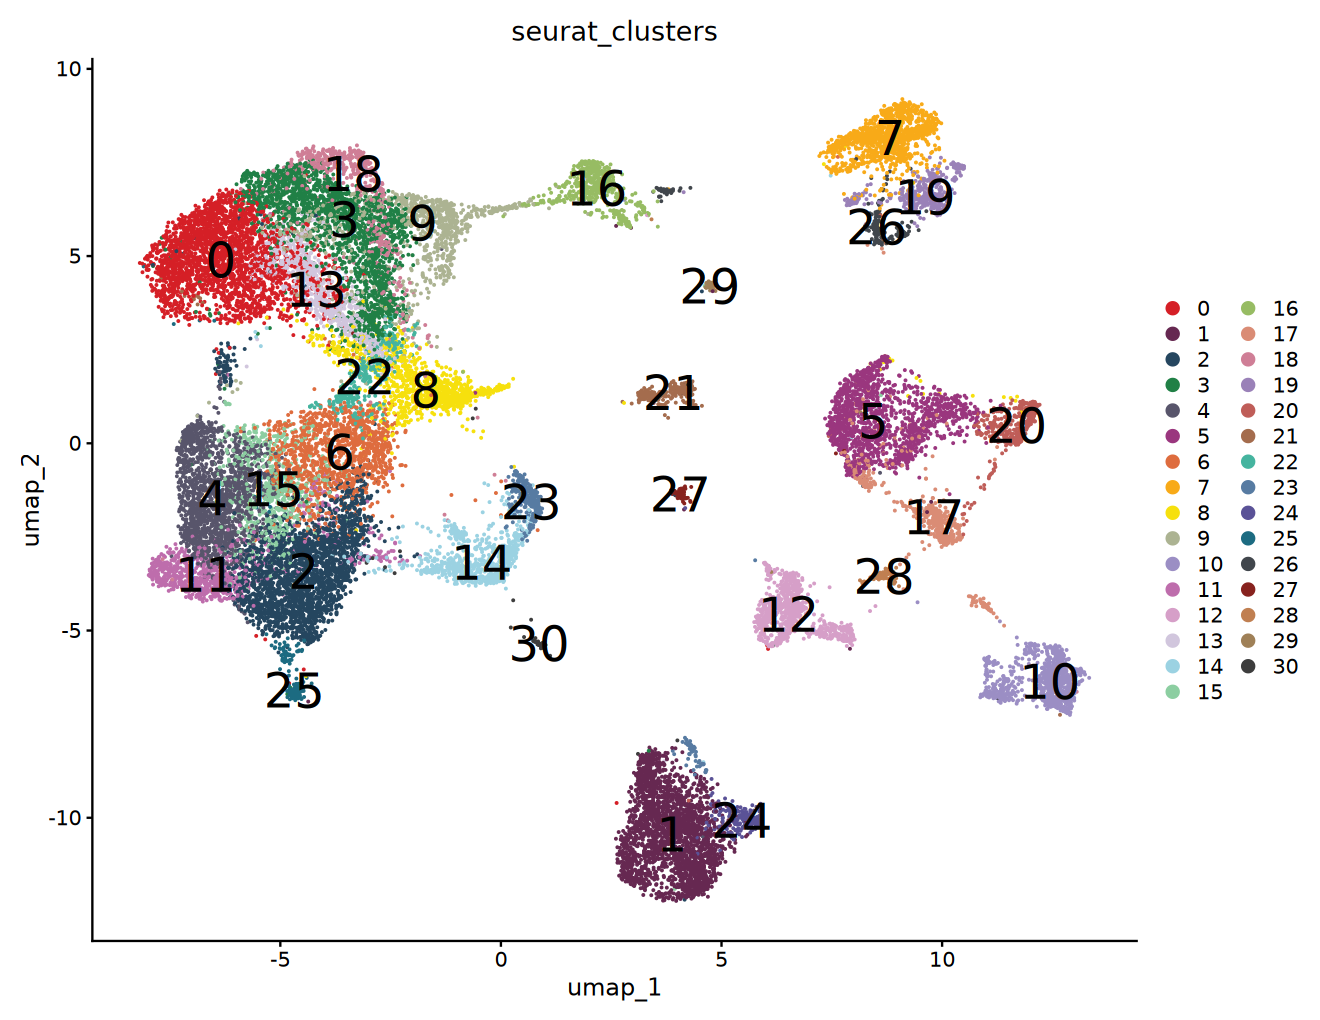

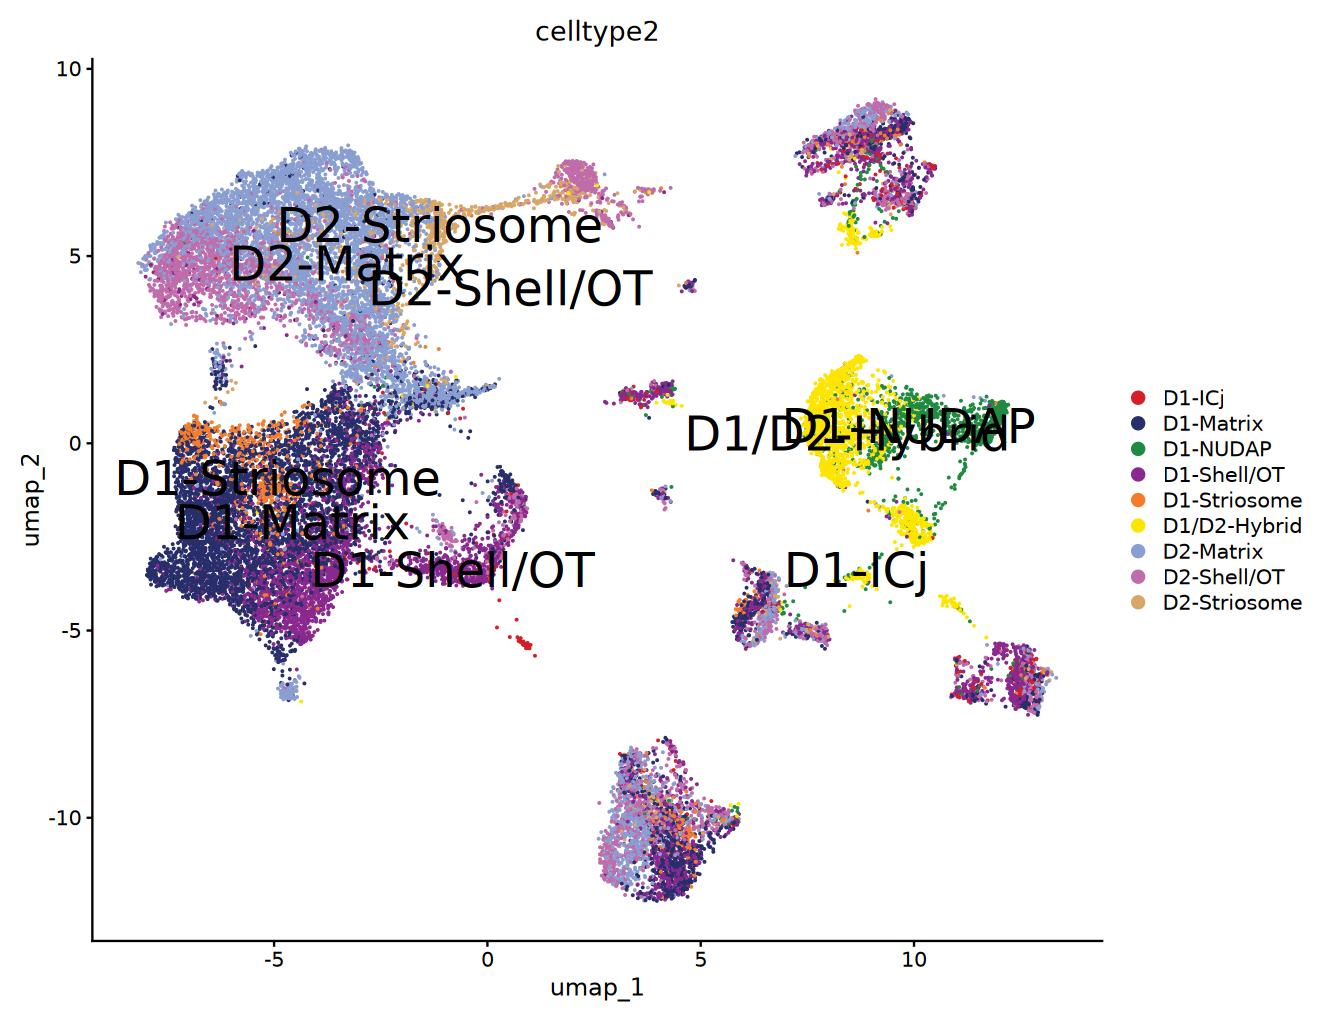

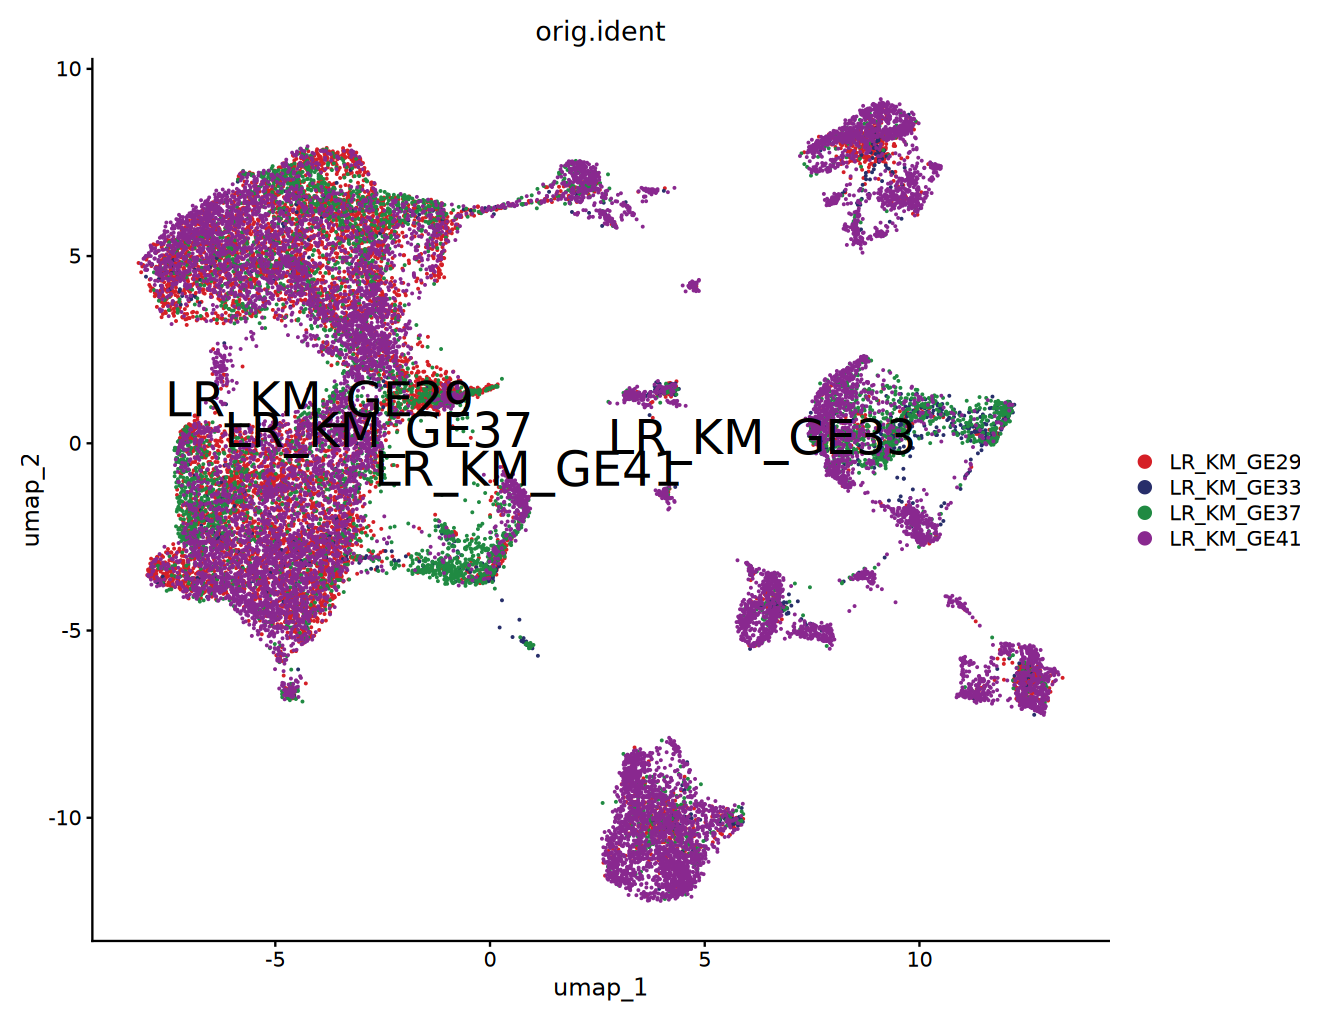

In [4]:
## plot the MSN sublabel
DimPlot(obj_msn, reduction = "umap", group.by = "seurat_clusters", label = TRUE, label.size = 10, 
        cols = ArchR::paletteDiscrete(unique(obj_msn$seurat_clusters)))
DimPlot(obj_msn, reduction = "umap", group.by = "celltype2", label = TRUE, label.size = 10, 
                cols = ArchR::paletteDiscrete(unique(obj_msn$celltype2)))
DimPlot(obj_msn, reduction = "umap", group.by = "orig.ident", label = TRUE, label.size = 10, 
                cols = ArchR::paletteDiscrete(unique(obj_msn$orig.ident)))

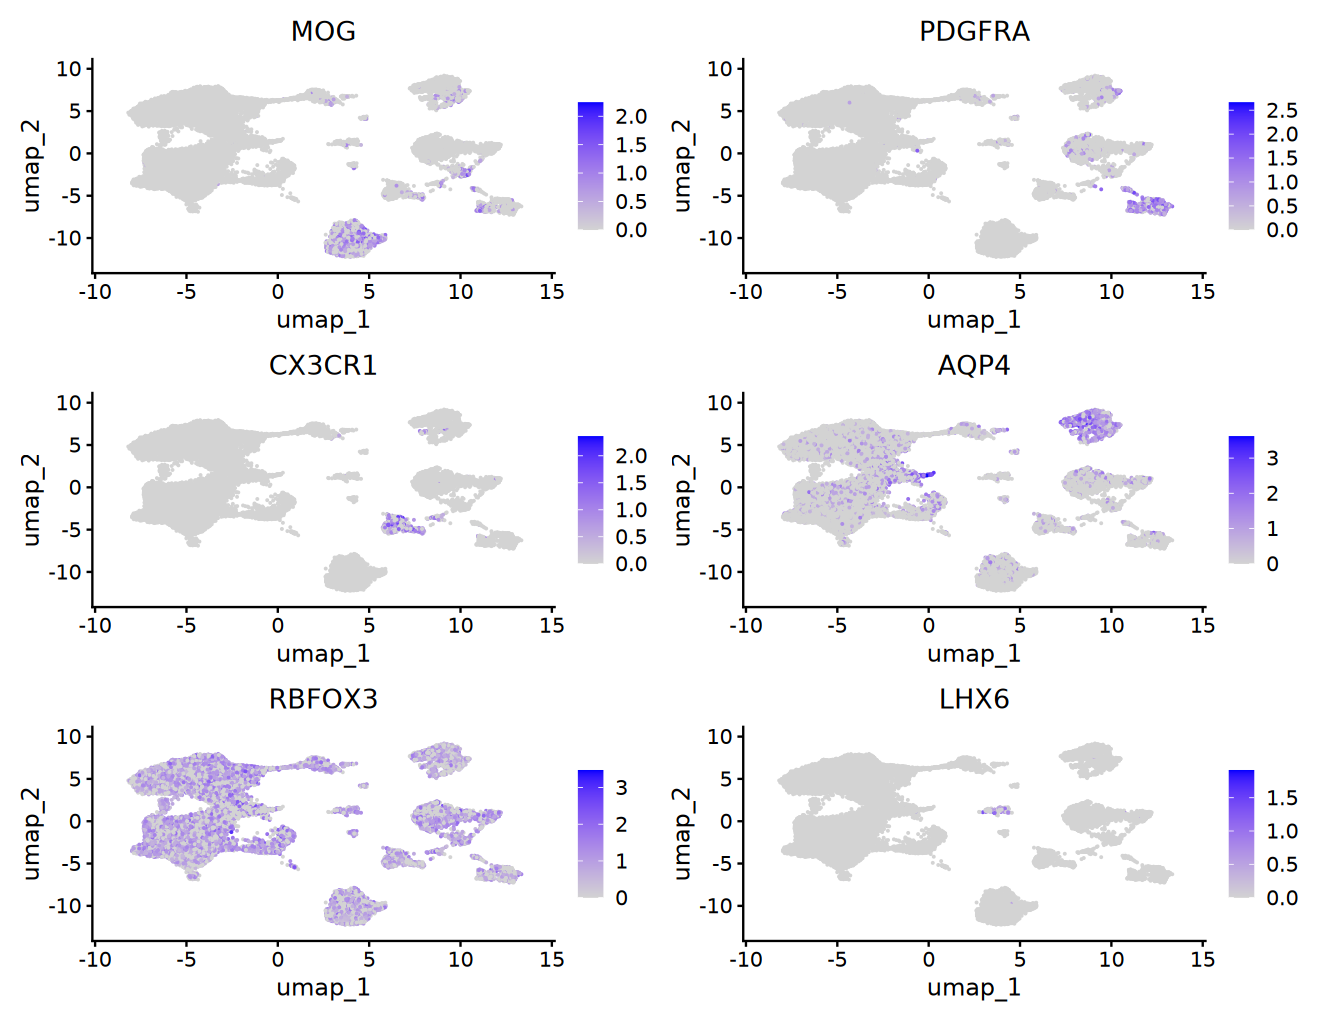

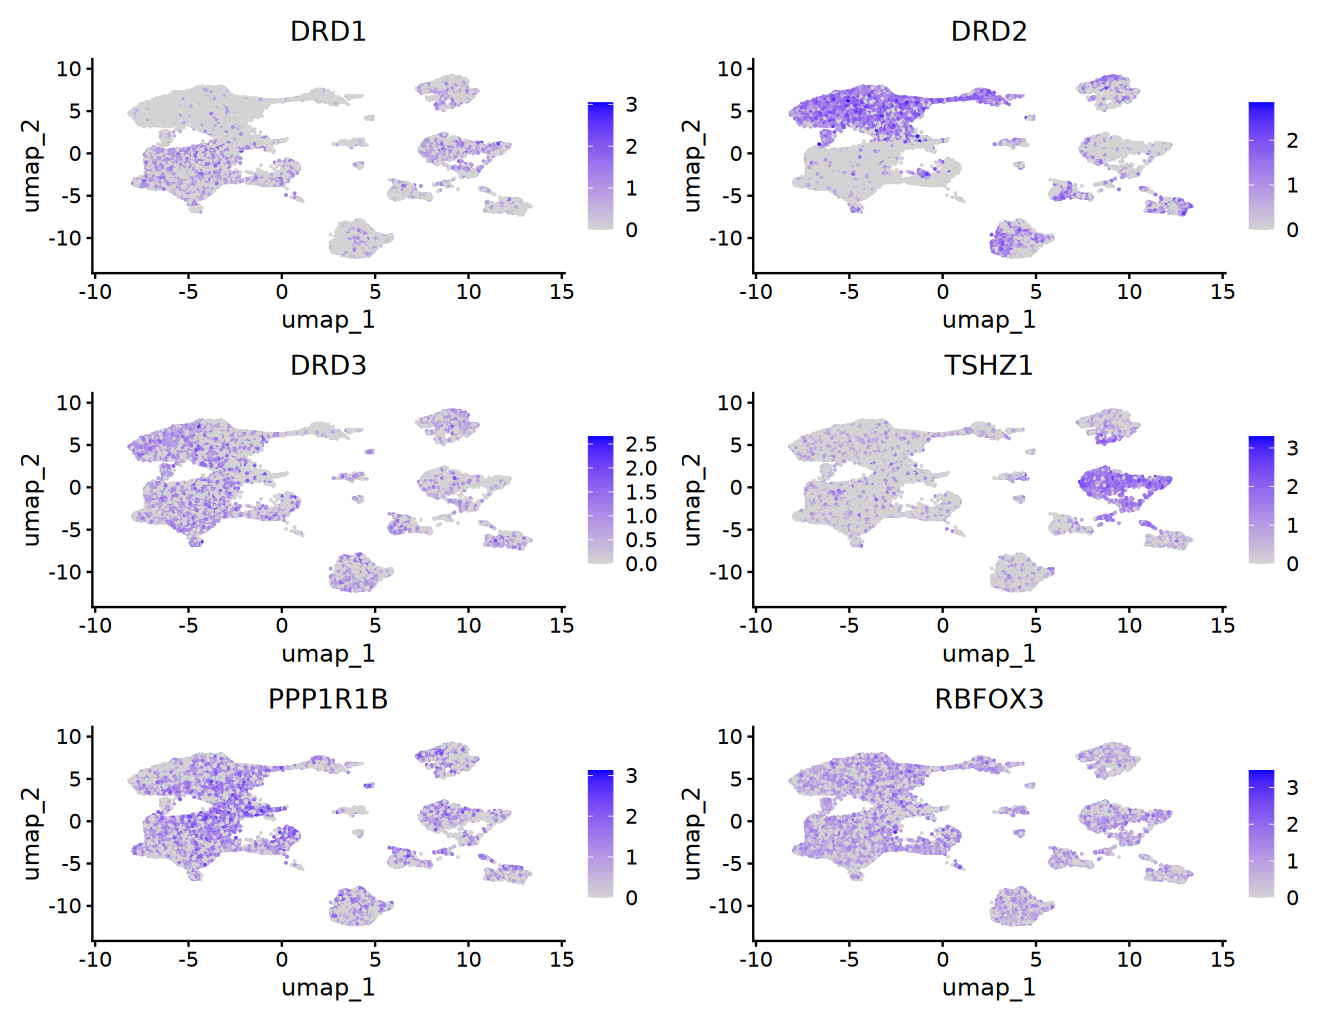

In [7]:
## off target genes
features = c('MOG', 'PDGFRA', 'CX3CR1', 'AQP4', 'RBFOX3', 'LHX6')
FeaturePlot(obj_msn, reduction = "umap", features = features)

## on target genes
features = c('DRD1', 'DRD2', 'DRD3', 'TSHZ1', 'PPP1R1B', 'RBFOX3')
FeaturePlot(obj_msn, reduction = "umap", features = features)

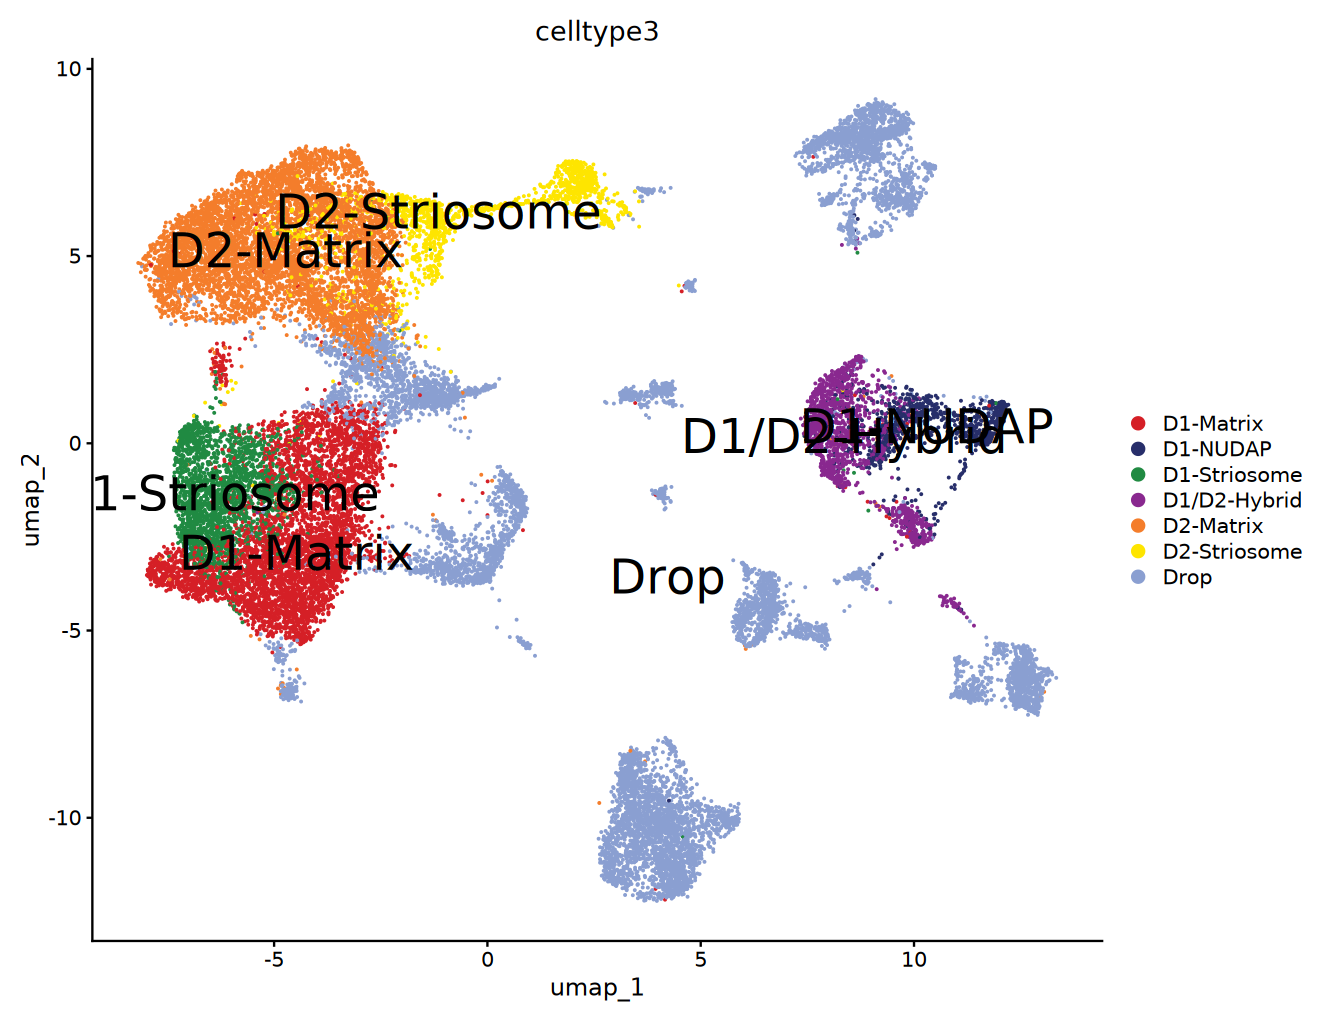

In [11]:
## using the UMAP embedding and majority clusters, relabel the MSN subtypes
obj_msn$celltype3 = obj_msn$celltype2

## the bad clusters
obj_msn$celltype3[obj_msn$seurat_clusters %in% c(1, 7, 8, 10, 12, 14, 19, 21:30)] = 'Drop'

## the matrix/striosome clusters
obj_msn$celltype3[obj_msn$seurat_clusters %in% c(2, 6, 11)] = 'D1-Matrix'
obj_msn$celltype3[obj_msn$seurat_clusters %in% c(4)] = 'D1-Striosome'

obj_msn$celltype3[obj_msn$seurat_clusters %in% c(0, 3, 13, 18)] = 'D2-Matrix'
obj_msn$celltype3[obj_msn$seurat_clusters %in% c(9, 16)] = 'D2-Striosome'

obj_msn$celltype3[obj_msn$celltype3 == 'D1-Shell/OT'] = 'D1-Matrix'
obj_msn$celltype3[obj_msn$celltype3 == 'D2-Shell/OT'] = 'D2-Matrix'
obj_msn$celltype3[obj_msn$celltype3 == 'D1-ICj'] = 'Drop'

## visualize the cluster assignments
DimPlot(obj_msn, reduction = "umap", group.by = "celltype3", label = TRUE, label.size = 10, 
                cols = ArchR::paletteDiscrete(unique(obj_msn$celltype3)))

In [12]:
## reduce the resolution 
obj_merged = obj_merged %>% FindClusters(resolution = 0.5, algorithm = 2, verbose = T)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 74756
Number of edges: 2833349

Running Louvain algorithm with multilevel refinement...
Maximum modularity in 10 random starts: 0.9564
Number of communities: 34
Elapsed time: 24 seconds


Length of unique values greater than palette, interpolating..



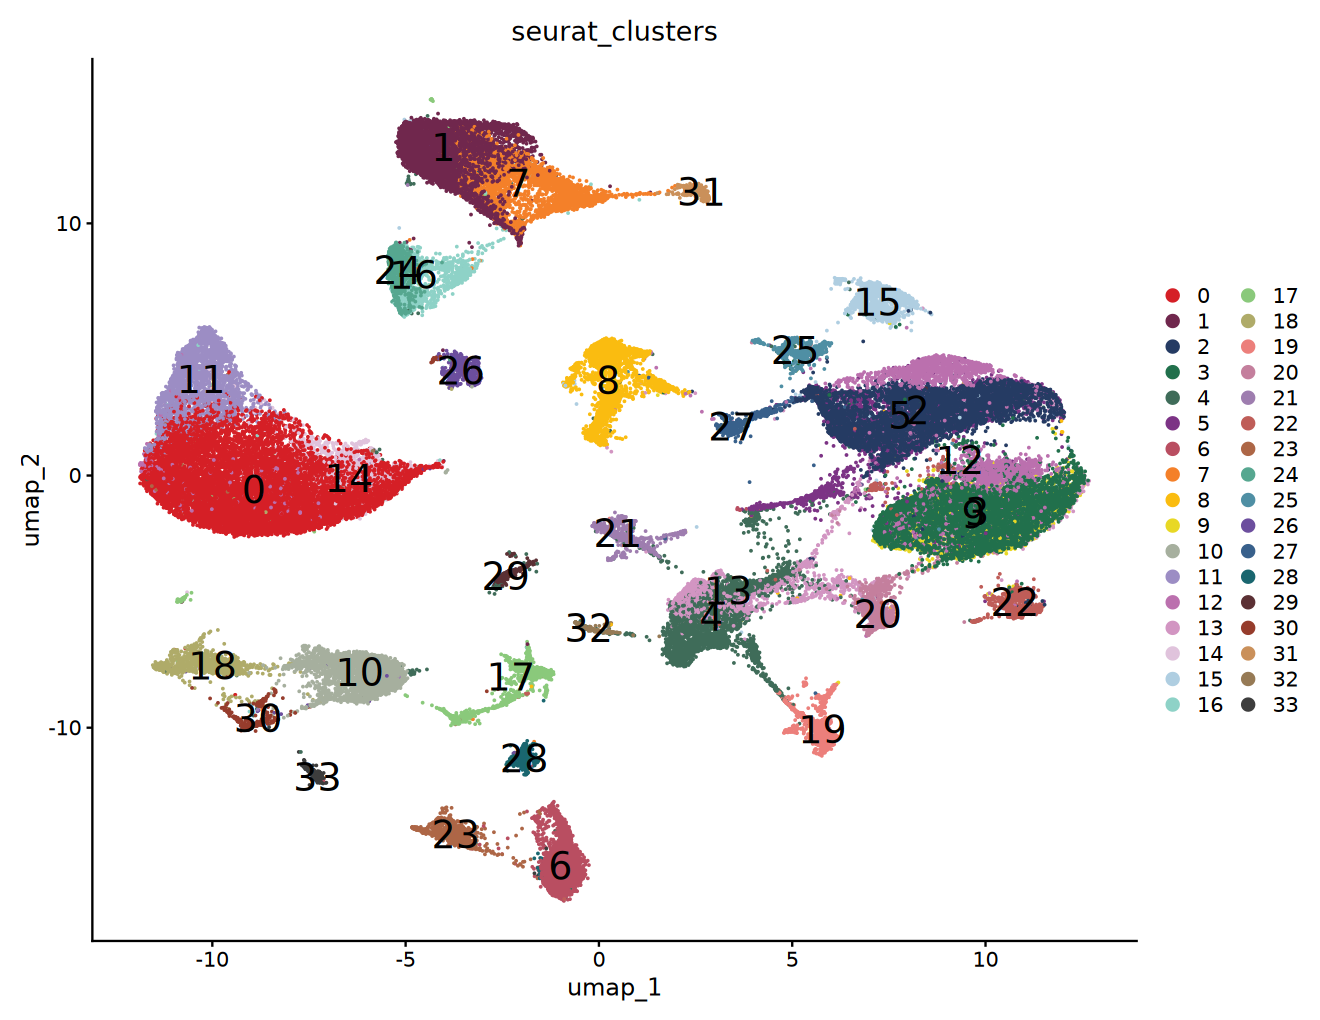

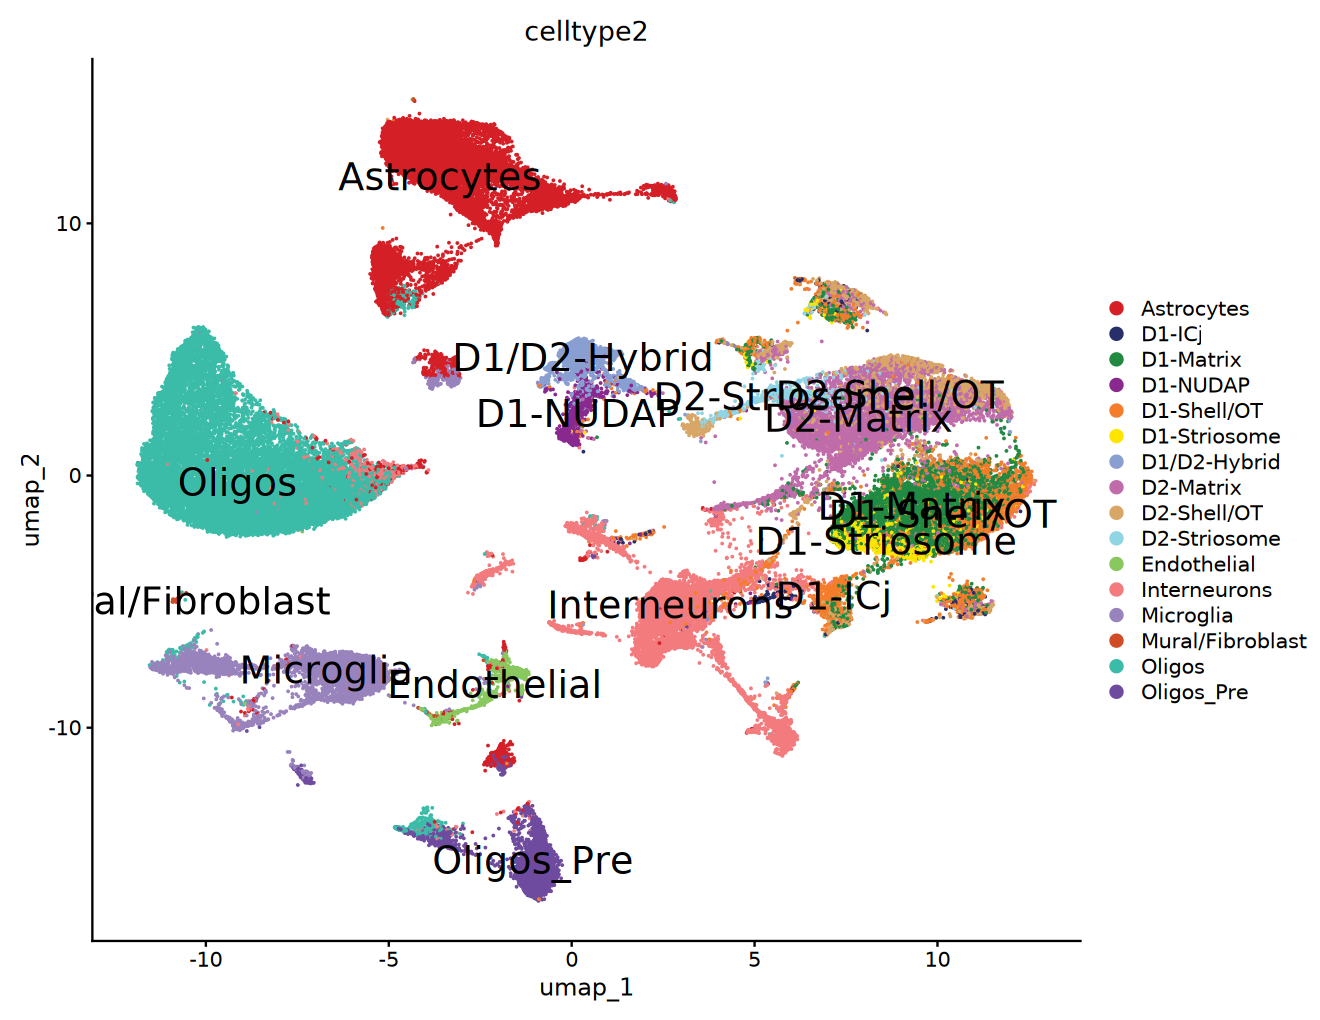

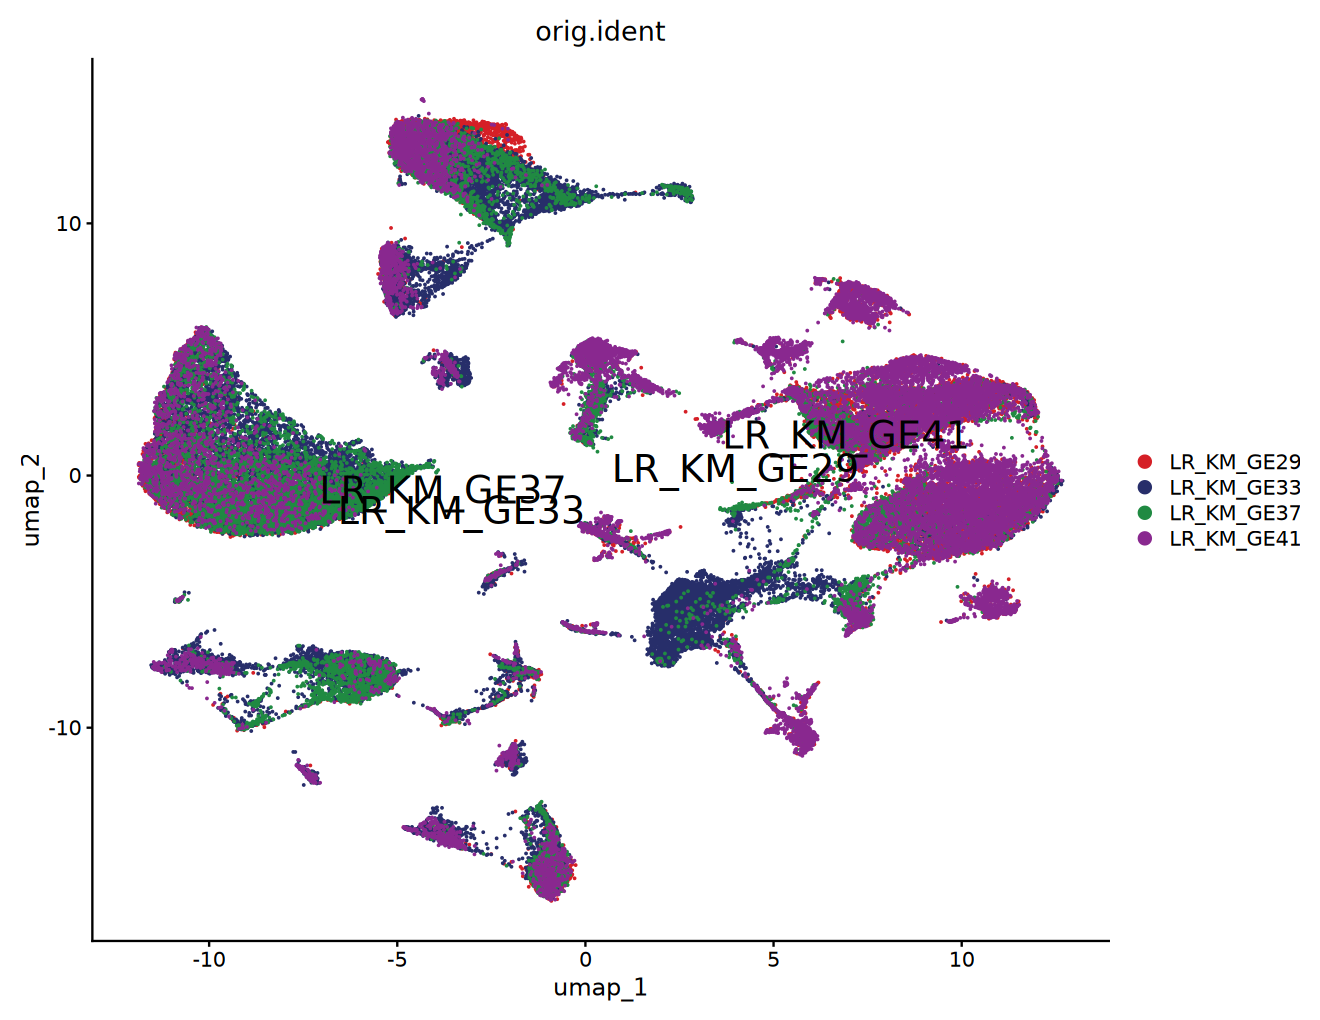

In [13]:
## plot the full dataset
DimPlot(obj_merged, reduction = "umap", group.by = "seurat_clusters", label = TRUE, label.size = 8, 
        cols = ArchR::paletteDiscrete(unique(obj_merged$seurat_clusters)))
DimPlot(obj_merged, reduction = "umap", group.by = "celltype2", label = TRUE, label.size = 8, 
                cols = ArchR::paletteDiscrete(unique(obj_merged$celltype2)))
DimPlot(obj_merged, reduction = "umap", group.by = "orig.ident", label = TRUE, label.size = 8, 
                cols = ArchR::paletteDiscrete(unique(obj_merged$orig.ident)))

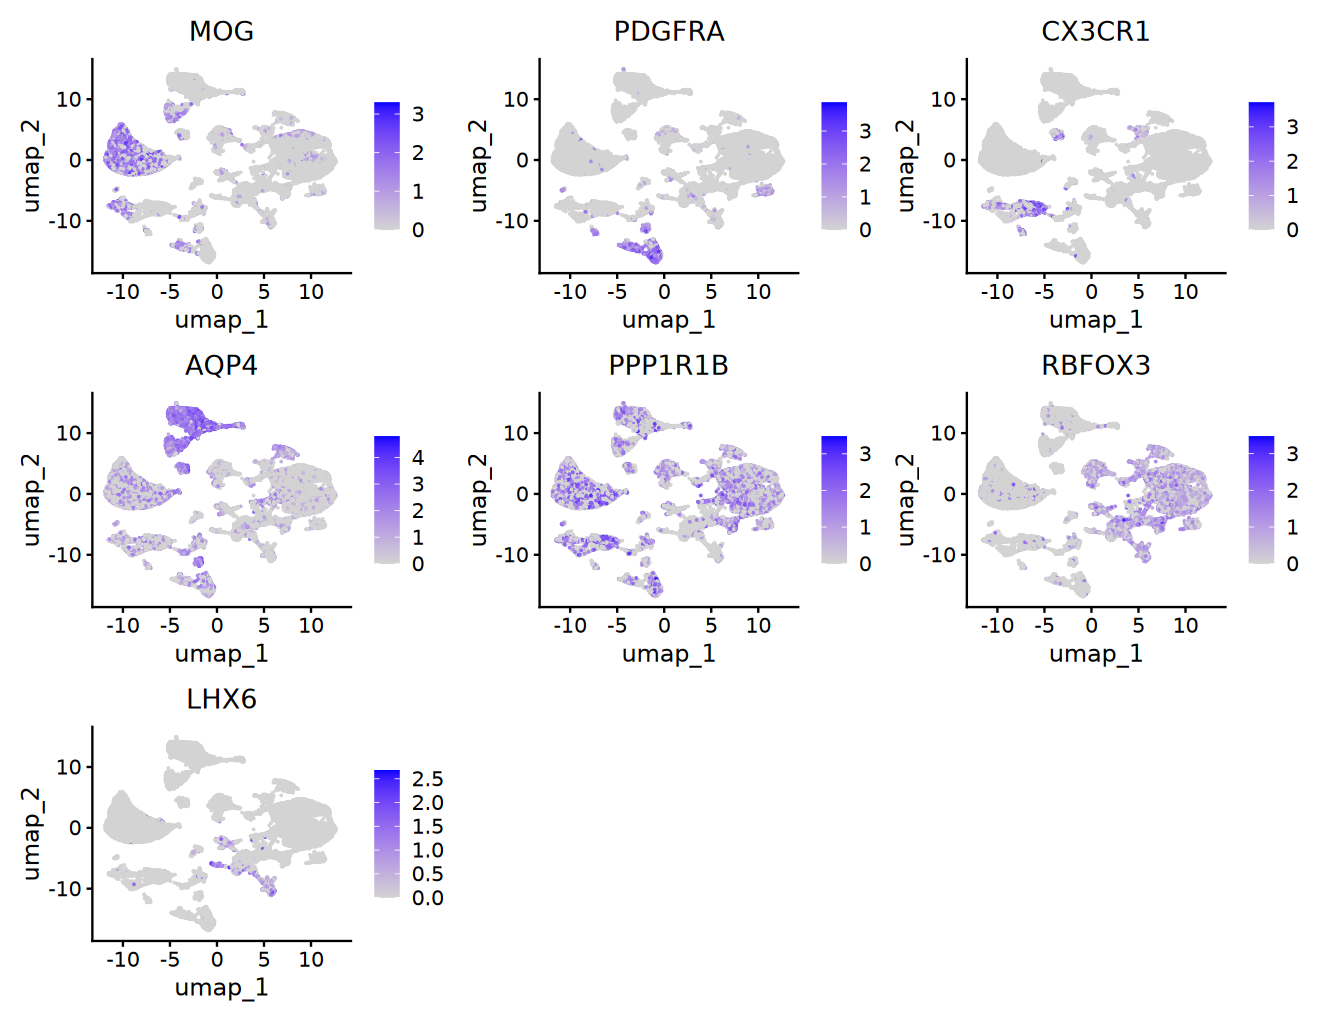

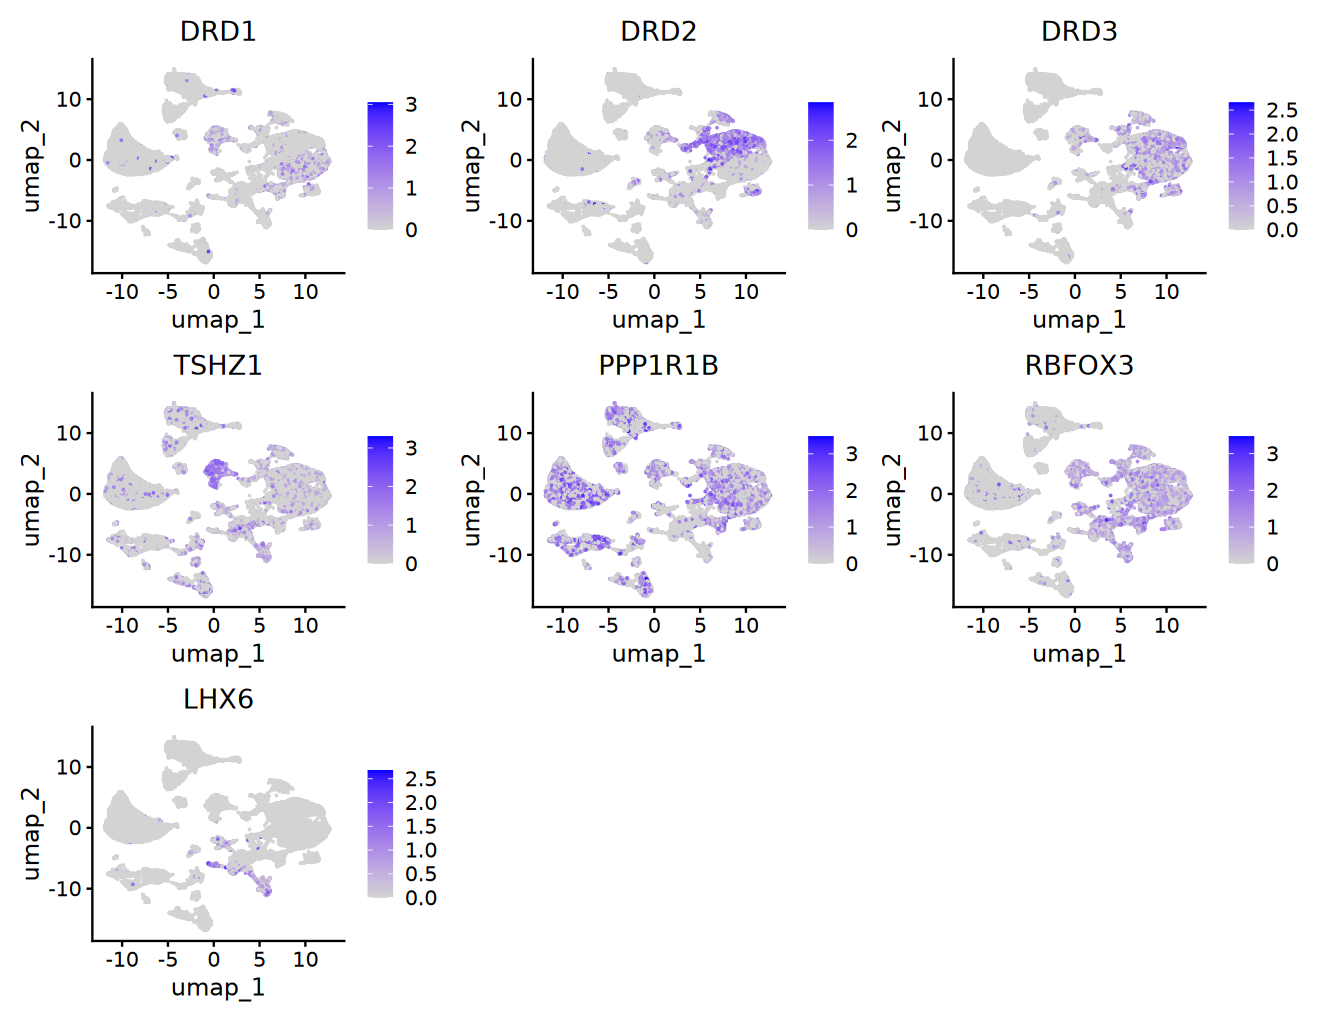

In [14]:
features = c('MOG', 'PDGFRA', 'CX3CR1', 'AQP4', 'PPP1R1B', 'RBFOX3', 'LHX6')
FeaturePlot(obj_merged, reduction = "umap", features = features)

features = c('DRD1', 'DRD2', 'DRD3', 'TSHZ1', 'PPP1R1B', 'RBFOX3', 'LHX6')
FeaturePlot(obj_merged, reduction = "umap", features = features)

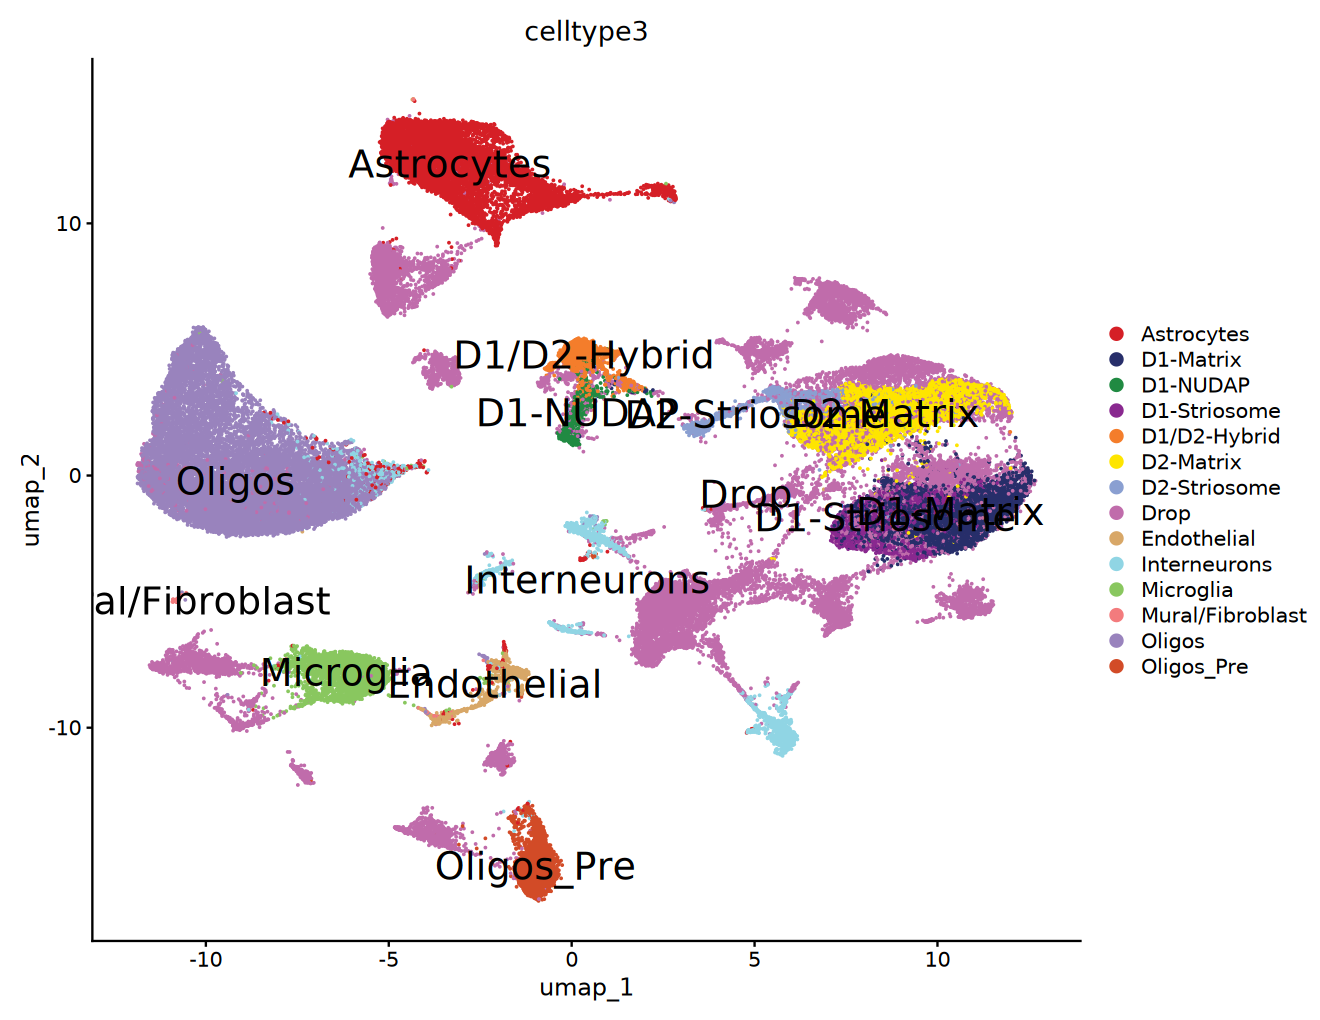

In [15]:
## using the UMAP embedding and majority clusters, relabel the rest of the cell types
obj_merged$celltype3 = obj_merged$celltype2

## add the MSN labels
ind = match(Cells(obj_msn), Cells(obj_merged))
obj_merged$celltype3[ind] = obj_msn$celltype3

## the bad clusters
to_drop = c(4, 5, 12, 13, 15, 16, 18, 25, 20, 22, 23, 24, 26, 28, 30, 33)
obj_merged$celltype3[obj_merged$seurat_clusters %in% to_drop] = 'Drop'

## visualize the cluster assignments
DimPlot(obj_merged, reduction = "umap", group.by = "celltype3", label = TRUE, label.size = 8, 
                cols = ArchR::paletteDiscrete(unique(obj_merged$celltype3)))

In [16]:
########################################################
# 5) subset the inter neurons, subcluster, and annotate
obj_int = obj_merged %>% 
  subset(subset = celltype1 == 'Interneurons') %>% 
  RunPCA(verbose = FALSE) %>% 
  FindNeighbors(dims = 1:30, verbose = FALSE) %>%
  RunUMAP(dims = 1:30, verbose = FALSE) %>% 
  FindClusters(resolution = 0.1, algorithm = 2,verbose = FALSE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


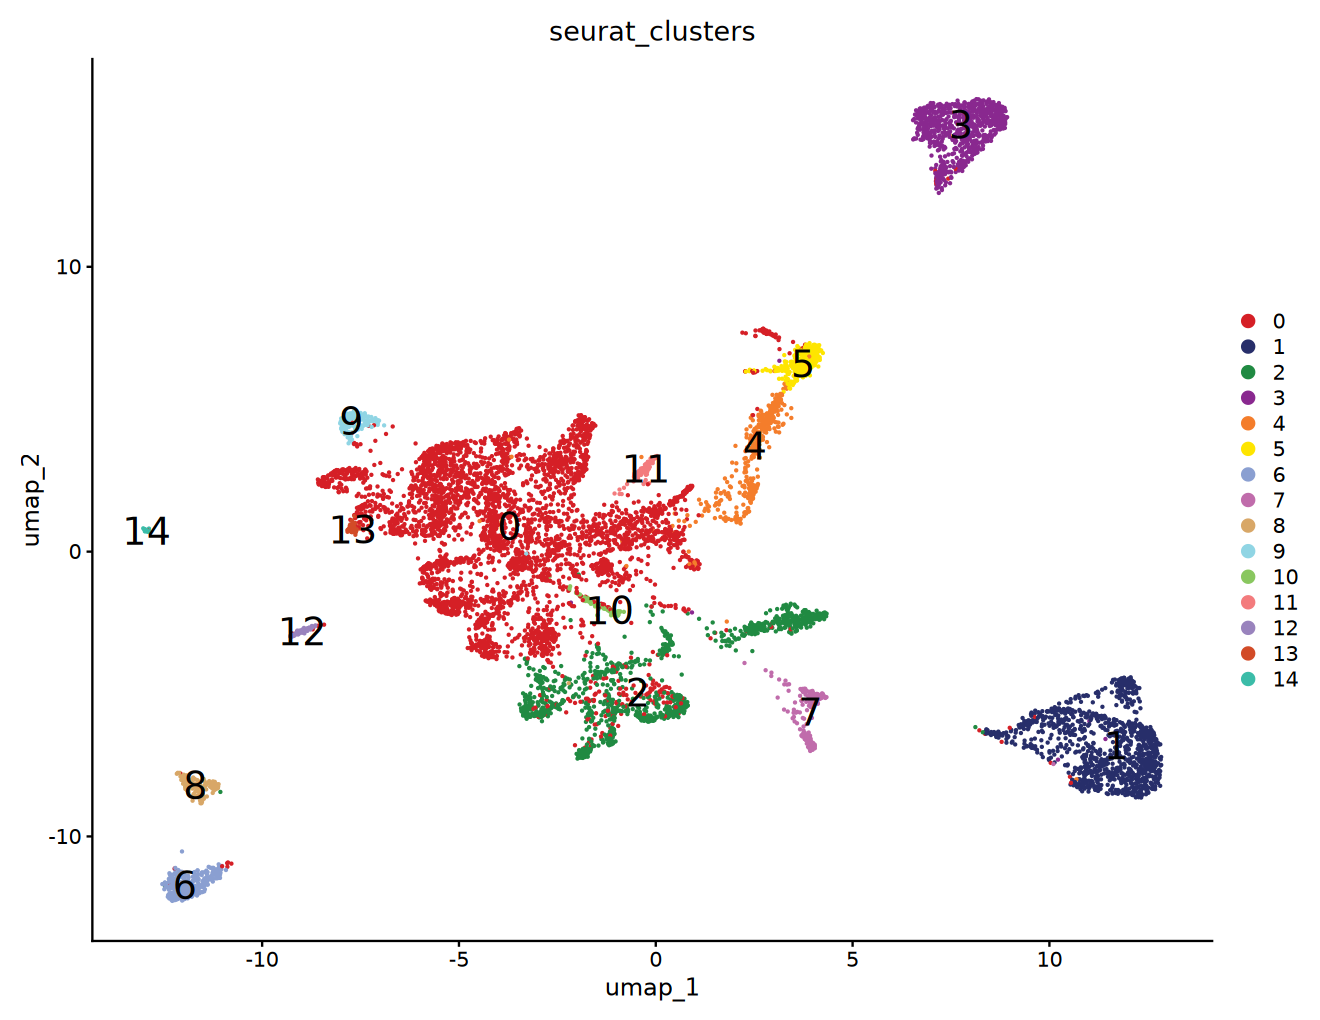

In [17]:
## visualize the cluster assignments
DimPlot(obj_int, reduction = "umap", group.by = "seurat_clusters", label = TRUE, label.size = 8, 
                cols = ArchR::paletteDiscrete(unique(obj_int$seurat_clusters)))

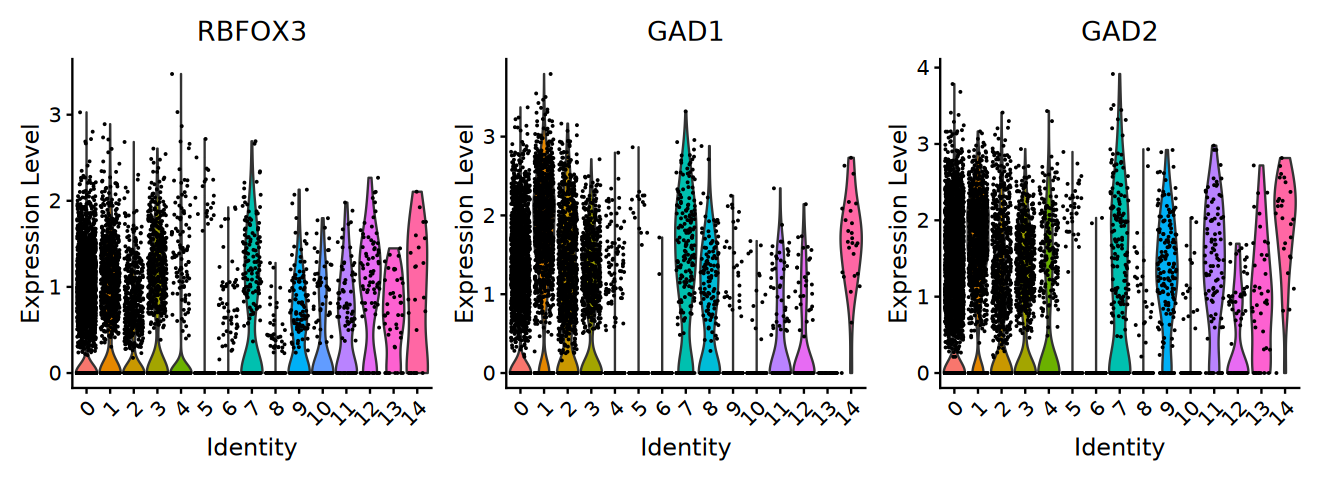

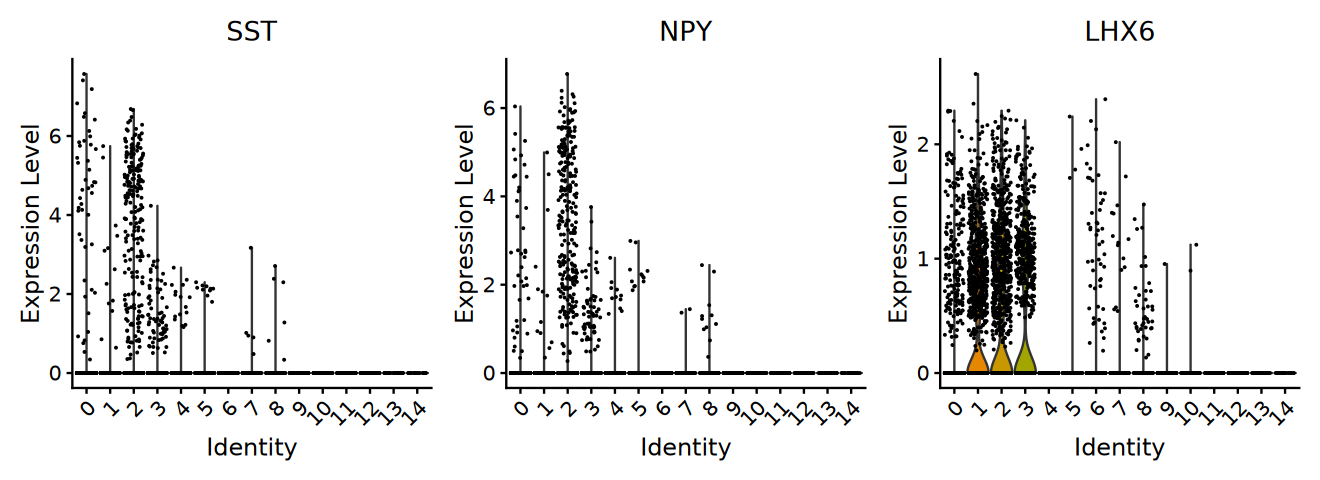

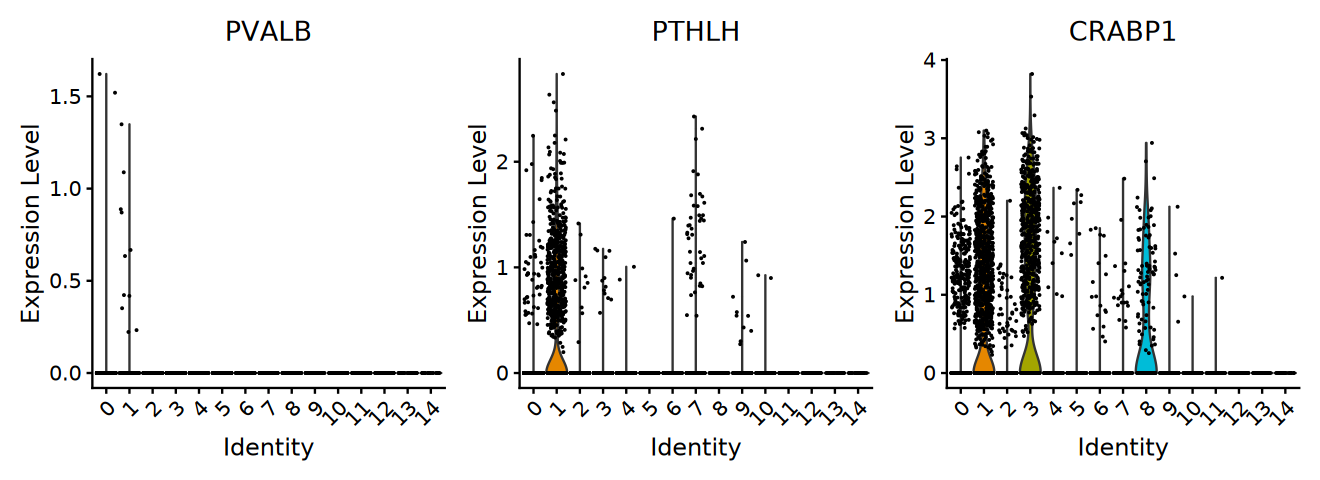

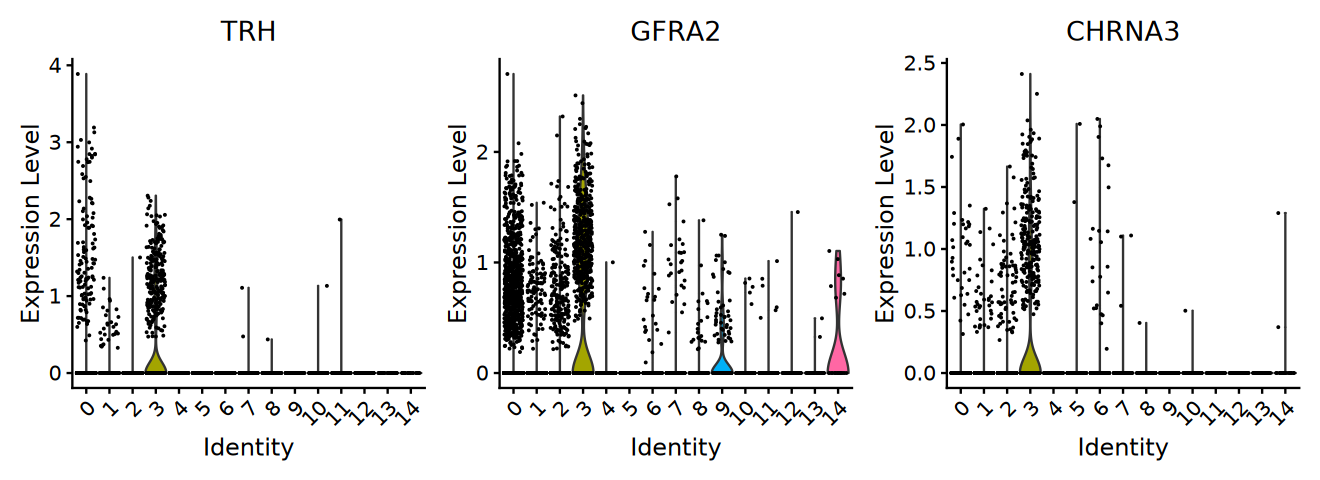

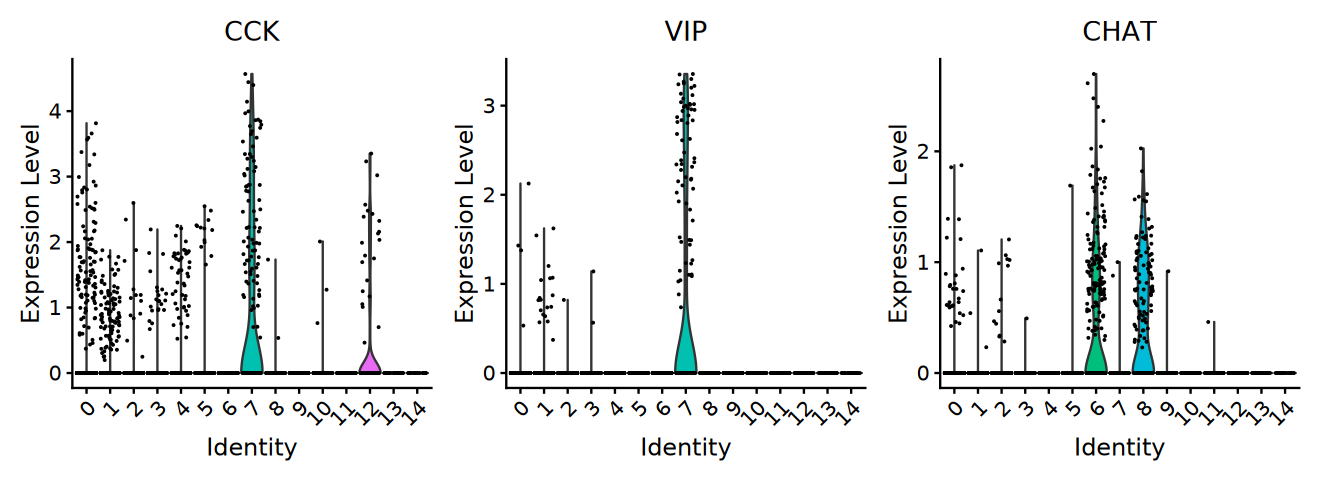

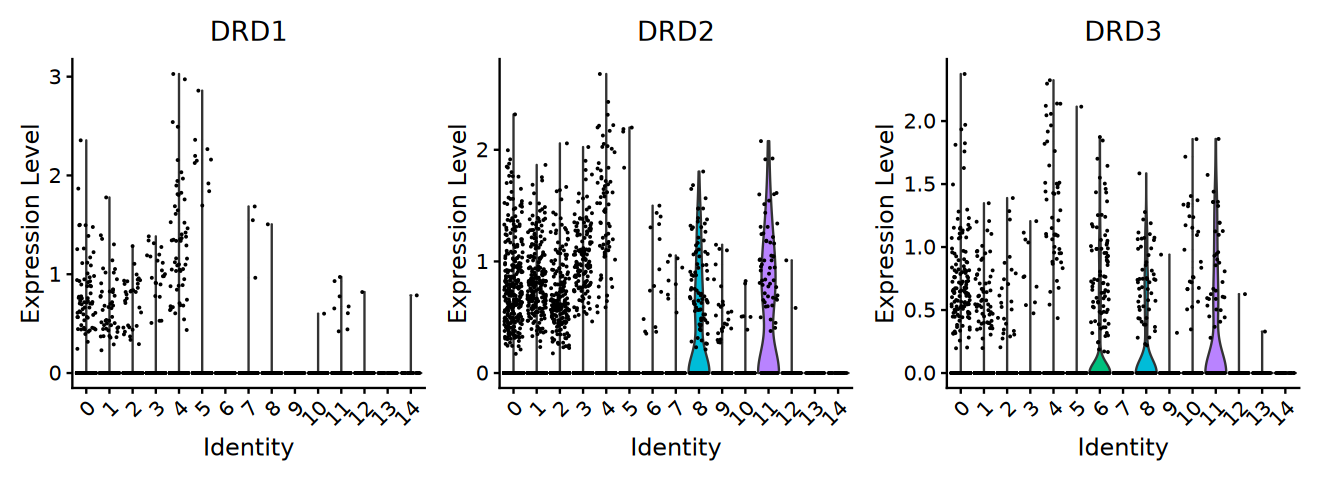

In [19]:
options(repr.plot.width=11, repr.plot.height=4)

## marker genes of striatal interneurons based on Munos-manchado et al.
features0 = c('Rbfox3', 'Gad1', 'Gad2') %>% toupper()
VlnPlot(obj_int, features = features0, group.by = 'seurat_clusters', assay = 'RNA')

features1 = c('Sst', 'Npy', 'Lhx6') %>% toupper()
VlnPlot(obj_int, features = features1, group.by = 'seurat_clusters', assay = 'RNA')

features2 = c('Pvalb', 'Pthlh', 'Crabp1') %>% toupper()
VlnPlot(obj_int, features = features2, group.by = 'seurat_clusters', assay = 'RNA')

features3 = c('Trh', 'Gfra2', 'Chrna3') %>% toupper()
VlnPlot(obj_int, features = features3, group.by = 'seurat_clusters', assay = 'RNA')

features4 = c('Cck', 'Vip', 'Chat') %>% toupper()
VlnPlot(obj_int, features = features4, group.by = 'seurat_clusters', assay = 'RNA')

features4 = c('Drd1', 'Drd2', 'Drd3') %>% toupper()
VlnPlot(obj_int, features = features4, group.by = 'seurat_clusters', assay = 'RNA')

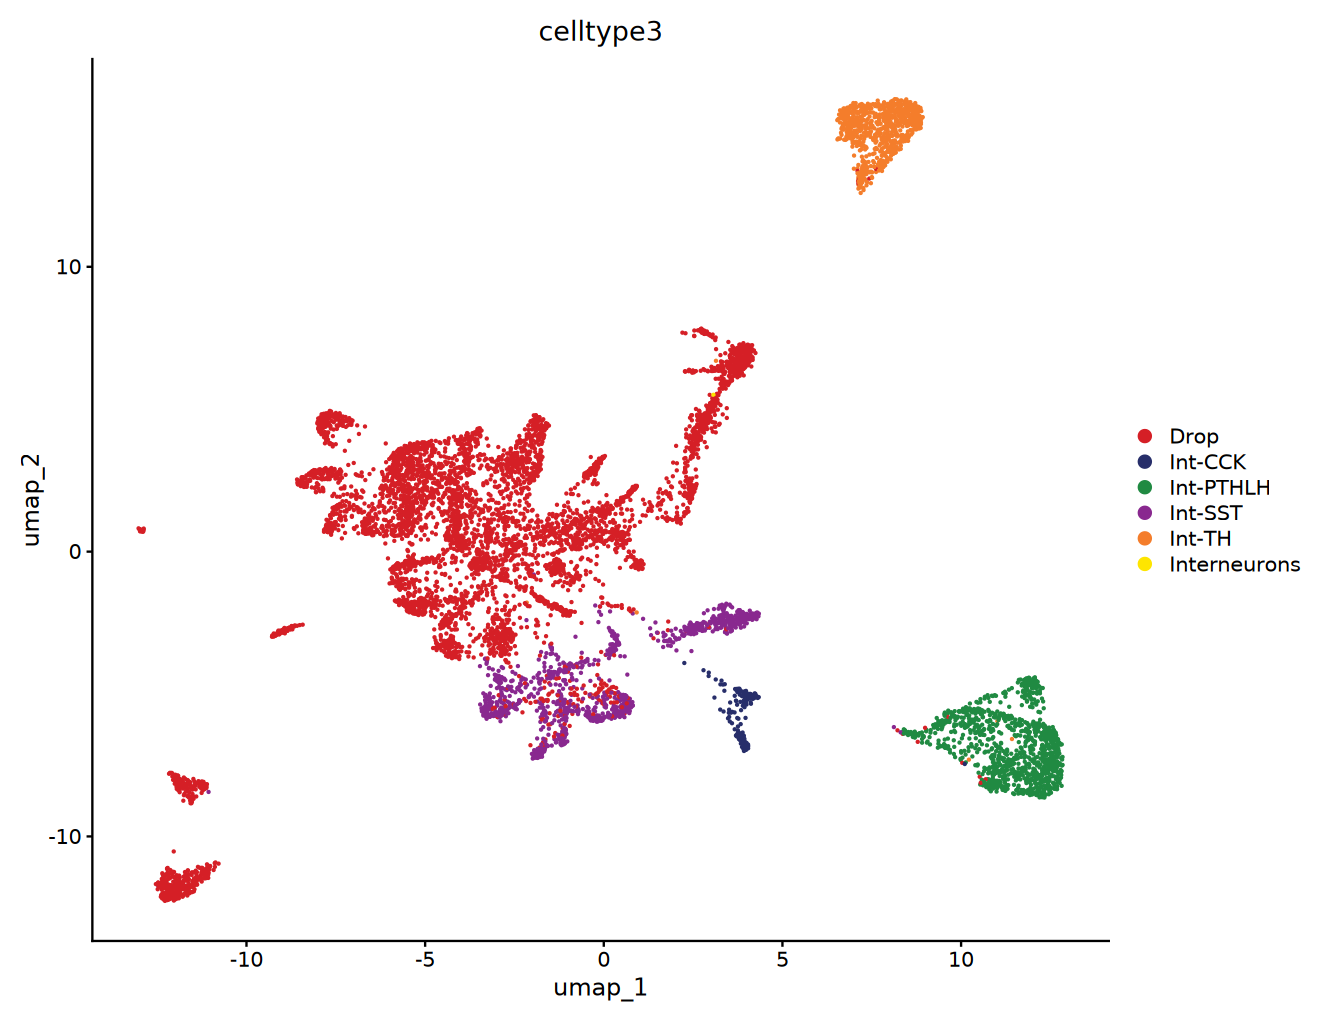

In [22]:
## using the UMAP embedding and majority clusters, relabel the MSN subtypes

## not gaba-ergic neuron cluster
obj_int$celltype3[obj_int$seurat_clusters %in% c(0, 5, 6, 8, 10:14)] = 'Drop'
obj_int$celltype3[grepl('^D1|^D2', obj_int$celltype3)] = 'Drop'

## Th cluster
obj_int$celltype3[obj_int$seurat_clusters %in% c(3)] = 'Int-TH'

## Pvalb/Pthlh cluster
obj_int$celltype3[obj_int$seurat_clusters %in% c(1)] = 'Int-PTHLH'

## Npy/Sst cluster
obj_int$celltype3[obj_int$seurat_clusters %in% c(2)] = 'Int-SST'

## Cck cluster
obj_int$celltype3[obj_int$seurat_clusters %in% c(7)] = 'Int-CCK'

## visualize the cluster assignments
DimPlot(obj_int, reduction = "umap", group.by = "celltype3", label = F, label.size = 10, 
                cols = ArchR::paletteDiscrete(unique(obj_int$celltype3)))

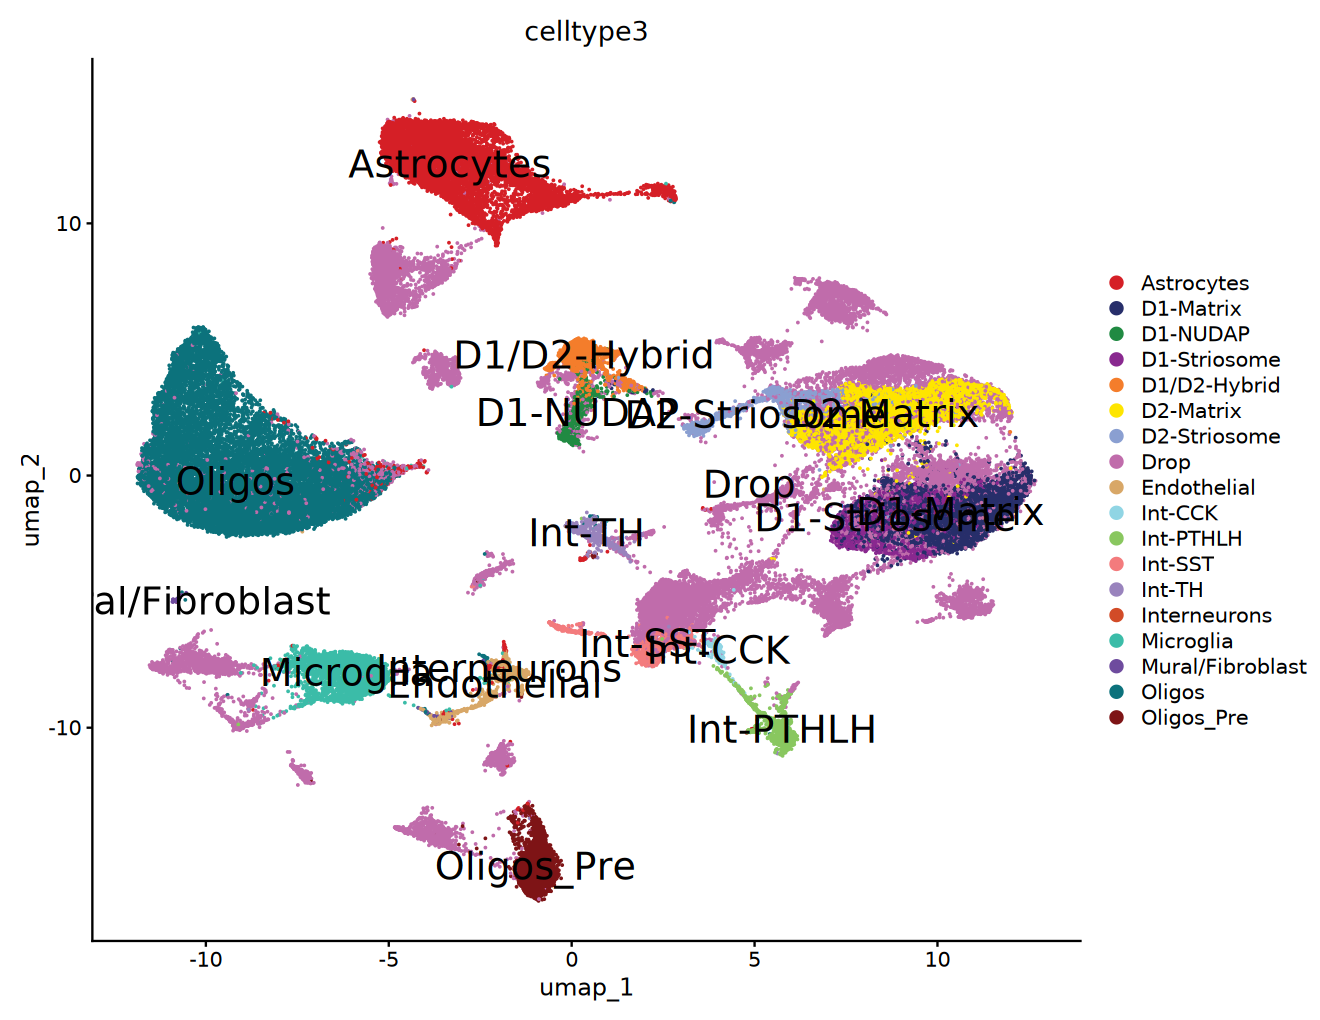

In [23]:
options(repr.plot.width=11, repr.plot.height=8.5)
## Add the interneuron sub clustering to the merged data
obj_merged$celltype3 = with(obj_merged[[]], ifelse(
    is.na(obj_int[['celltype3']][colnames(obj_merged),]), 
    celltype3, obj_int[['celltype3']][colnames(obj_merged),]))

## visualize the refined cluster assignments w/ interneuron subtypes
DimPlot(obj_merged, reduction = "umap", group.by = "celltype3", label = TRUE, label.size = 8, 
                cols = ArchR::paletteDiscrete(unique(obj_merged$celltype3)))

In [24]:
obj_merged = obj_merged %>% 
    subset(subset = celltype3 != 'Drop' & celltype3 != 'Interneurons') %>% 
    RunPCA(verbose = FALSE) %>% 
    FindNeighbors(dims = 1:30, verbose = FALSE) %>%
    RunUMAP(dims = 1:30, verbose = FALSE)

In [ ]:
## visualize the refined cluster assignments w/ interneuron subtypes
table(obj_merged$celltype3)
DimPlot(obj_merged, reduction = "umap", group.by = "celltype3", label = TRUE, label.size =6, 
                cols = ArchR::paletteDiscrete(unique(obj_merged$celltype3)))


      Astrocytes        D1-Matrix         D1-NUDAP     D1-Striosome 
            9800             4742              977             2174 
    D1/D2-Hybrid        D2-Matrix     D2-Striosome      Endothelial 
            1553             3581             1115             1041 
         Int-CCK        Int-PTHLH          Int-SST           Int-TH 
             203             1165             1129              833 
       Microglia Mural/Fibroblast           Oligos       Oligos_Pre 
            2725              141            15356             3695 

In [ ]:
################################
# 6) save the refined clusters

## export the metadata
save_meta_fn = here('data/tidy_data/tables',"Gayden_NAc_refined_all_SeuratObj_N22.txt.gz")
write_tsv(obj_merged@meta.data, save_meta_fn)

## save in the full dataset for label refinement
save_merged_fn = here('data/tidy_data/Human_Gayden', 
                        "Gayden_NAc_refined_all_SeuratObj_N22.rds")
saveRDS(obj_merged, file = save_merged_fn)

In [26]:
obj_msn = obj_msn %>% 
    subset(subset = celltype3 != c('Drop')) %>% 
    RunPCA(verbose = FALSE) %>% 
    FindNeighbors(dims = 1:30, verbose = FALSE) %>%
    RunUMAP(dims = 1:30, verbose = FALSE)

In [31]:
obj_msn = obj_msn %>% FindVariableFeatures(verbose = F) %>% 
ScaleData(verbose = F) %>% RunPCA(verbose = F)

obj_msn = IntegrateLayers(object = obj_msn, method = RPCAIntegration, k.anchor = 25,
                      orig.reduction = "pca", new.reduction = "integrated.rpca", 
                      normalization.method = "LogNormalize", dims = 1:30, verbose = F) 

obj_msn = obj_msn %>% RunUMAP(reduction = "integrated.rpca", dims = 1:30) %>% 
  FindNeighbors(reduction = "integrated.rpca", dims = 1:30, verbose = F) %>% 
  FindClusters(resolution = 1, algorithm = 2, verbose = F)

Warning message:
“Different features in new layer data than already exists for scale.data”
17:19:09 UMAP embedding parameters a = 0.9922 b = 1.112

17:19:09 Read 17268 rows and found 30 numeric columns

17:19:09 Using Annoy for neighbor search, n_neighbors = 30

17:19:09 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:19:11 Writing NN index file to temp file /tmp/RtmpkXgAA1/file46e9d28a45277

17:19:11 Searching Annoy index using 12 threads, search_k = 3000

17:19:17 Annoy recall = 100%

17:19:18 Commencing smooth kNN distance calibration using 12 threads
 with target n_neighbors = 30

17:19:19 Initializing from normalized Laplacian + noise (using RSpectra)

17:19:20 Commencing optimization for 200 epochs, with 759306 positive edges

17:19:46 Optimization finished



Length of unique values greater than palette, interpolating..



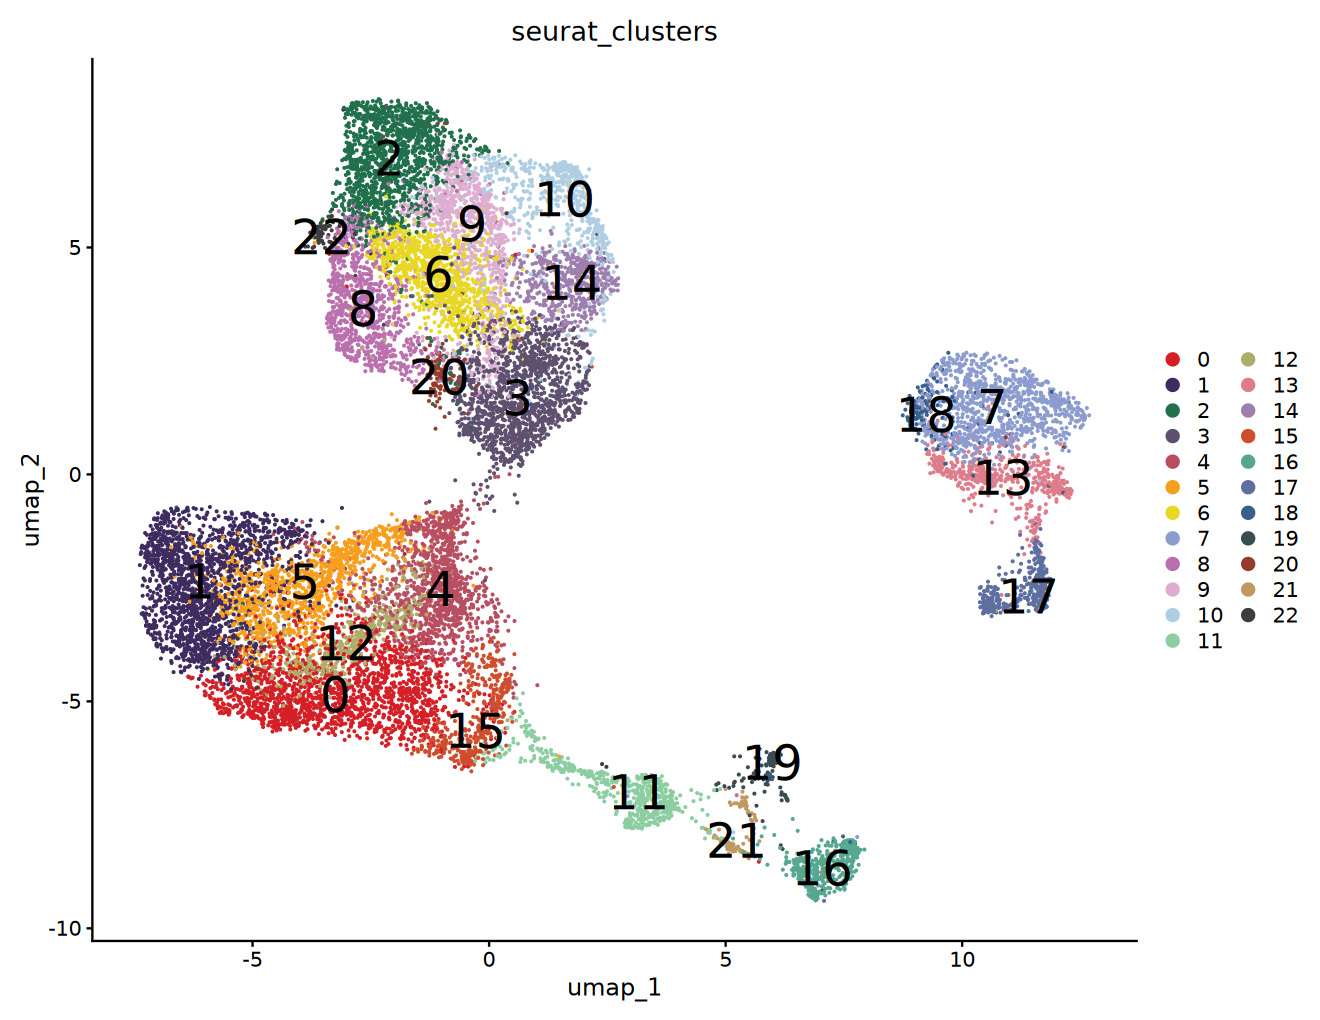

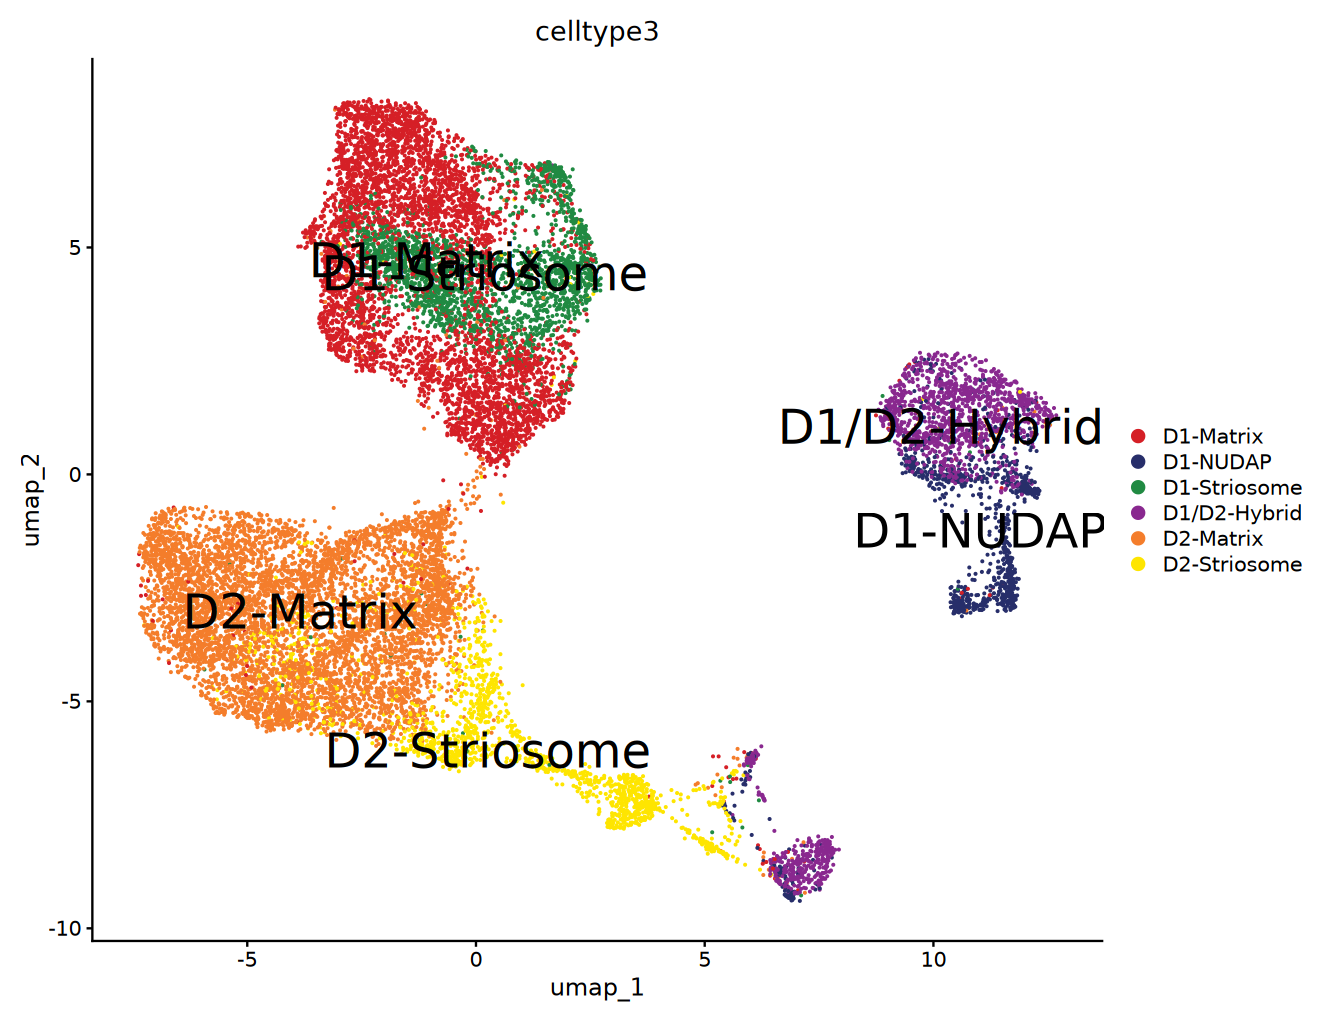

In [33]:
## plot the MSN sublabel
DimPlot(obj_msn, reduction = "umap", group.by = "seurat_clusters", label = TRUE, label.size = 10, 
        cols = ArchR::paletteDiscrete(unique(obj_msn$seurat_clusters)))
DimPlot(obj_msn, reduction = "umap", group.by = "celltype3", label = TRUE, label.size = 10, 
                cols = ArchR::paletteDiscrete(unique(obj_msn$celltype3)))

In [34]:
obj_msn = obj_msn %>% 
    subset(subset = celltype3 != c(21, 19, 16))

In [35]:
## save in the MSN dataset for label refinement
save_subset_msn = here('data/tidy_data/Human_Gayden', 
                        "Gayden_NAc_refined_msn_SeuratObj_N22.rds")
saveRDS(obj_msn, file = save_subset_msn)